In [4]:
import os
import itertools
from PIL import Image

# Data Handling Tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Generate data paths with labels
train_data_dir = 'chest_xray/train'
filepaths = []
labels = []
folds = os.listdir(train_data_dir) # List of All directory with Train Directory, return 'PNEUMNONIA' & 'NORMAL'
for fold in folds:
    foldpath = os.path.join(train_data_dir,fold)
    fileList = os.listdir(foldpath)
    for file in fileList:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

# Create a New DataFrame
train_df = pd.concat([FSeries, LSeries], axis=1)
train_df

,filepaths,labels
0,chest_xray/train\NORMAL\IM-0115-0001.jpeg,NORMAL
1,chest_xray/train\NORMAL\IM-0117-0001.jpeg,NORMAL
2,chest_xray/train\NORMAL\IM-0119-0001.jpeg,NORMAL
3,chest_xray/train\NORMAL\IM-0122-0001.jpeg,NORMAL
4,chest_xray/train\NORMAL\IM-0125-0001.jpeg,NORMAL
...,...,...
5211,chest_xray/train\PNEUMONIA\person99_virus_183....,PNEUMONIA
5212,chest_xray/train\PNEUMONIA\person9_bacteria_38...,PNEUMONIA
5213,chest_xray/train\PNEUMONIA\person9_bacteria_39...,PNEUMONIA
5214,chest_xray/train\PNEUMONIA\person9_bacteria_40...,PNEUMONIA


In [6]:
# Generate data paths with labels
test_data_dir = 'chest_xray/test'
filepaths = []
labels = []
folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    fileList = os.listdir(foldpath)
    for file in fileList:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)
FSeries = pd.Series(filepaths,name='filepaths')
LSeries = pd.Series(labels,name='labels')
test_df = pd.concat([FSeries,LSeries], axis=1)
test_df

,filepaths,labels
0,chest_xray/test\NORMAL\IM-0001-0001.jpeg,NORMAL
1,chest_xray/test\NORMAL\IM-0003-0001.jpeg,NORMAL
2,chest_xray/test\NORMAL\IM-0005-0001.jpeg,NORMAL
3,chest_xray/test\NORMAL\IM-0006-0001.jpeg,NORMAL
4,chest_xray/test\NORMAL\IM-0007-0001.jpeg,NORMAL
...,...,...
619,chest_xray/test\PNEUMONIA\person96_bacteria_46...,PNEUMONIA
620,chest_xray/test\PNEUMONIA\person96_bacteria_46...,PNEUMONIA
621,chest_xray/test\PNEUMONIA\person97_bacteria_46...,PNEUMONIA
622,chest_xray/test\PNEUMONIA\person99_bacteria_47...,PNEUMONIA


In [7]:
# Generate data paths with labels
val_data_dir = 'chest_xray/val'
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir,fold)
    fileList = os.listdir(foldpath)
    for file in fileList:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)
FSeries = pd.Series(filepaths,name='filepaths')
LSeries = pd.Series(labels,name='labels')
valid_df = pd.concat([FSeries,LSeries], axis=1)
valid_df

,filepaths,labels
0,chest_xray/val\NORMAL\NORMAL2-IM-1427-0001.jpeg,NORMAL
1,chest_xray/val\NORMAL\NORMAL2-IM-1430-0001.jpeg,NORMAL
2,chest_xray/val\NORMAL\NORMAL2-IM-1431-0001.jpeg,NORMAL
3,chest_xray/val\NORMAL\NORMAL2-IM-1436-0001.jpeg,NORMAL
4,chest_xray/val\NORMAL\NORMAL2-IM-1437-0001.jpeg,NORMAL
5,chest_xray/val\NORMAL\NORMAL2-IM-1438-0001.jpeg,NORMAL
6,chest_xray/val\NORMAL\NORMAL2-IM-1440-0001.jpeg,NORMAL
7,chest_xray/val\NORMAL\NORMAL2-IM-1442-0001.jpeg,NORMAL
8,chest_xray/val\PNEUMONIA\person1946_bacteria_4...,PNEUMONIA
9,chest_xray/val\PNEUMONIA\person1946_bacteria_4...,PNEUMONIA


In [8]:
# PreProcessing
batch_size = 16
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size = img_size, class_mode = 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size = img_size, class_mode = 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',target_size = img_size, class_mode = 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


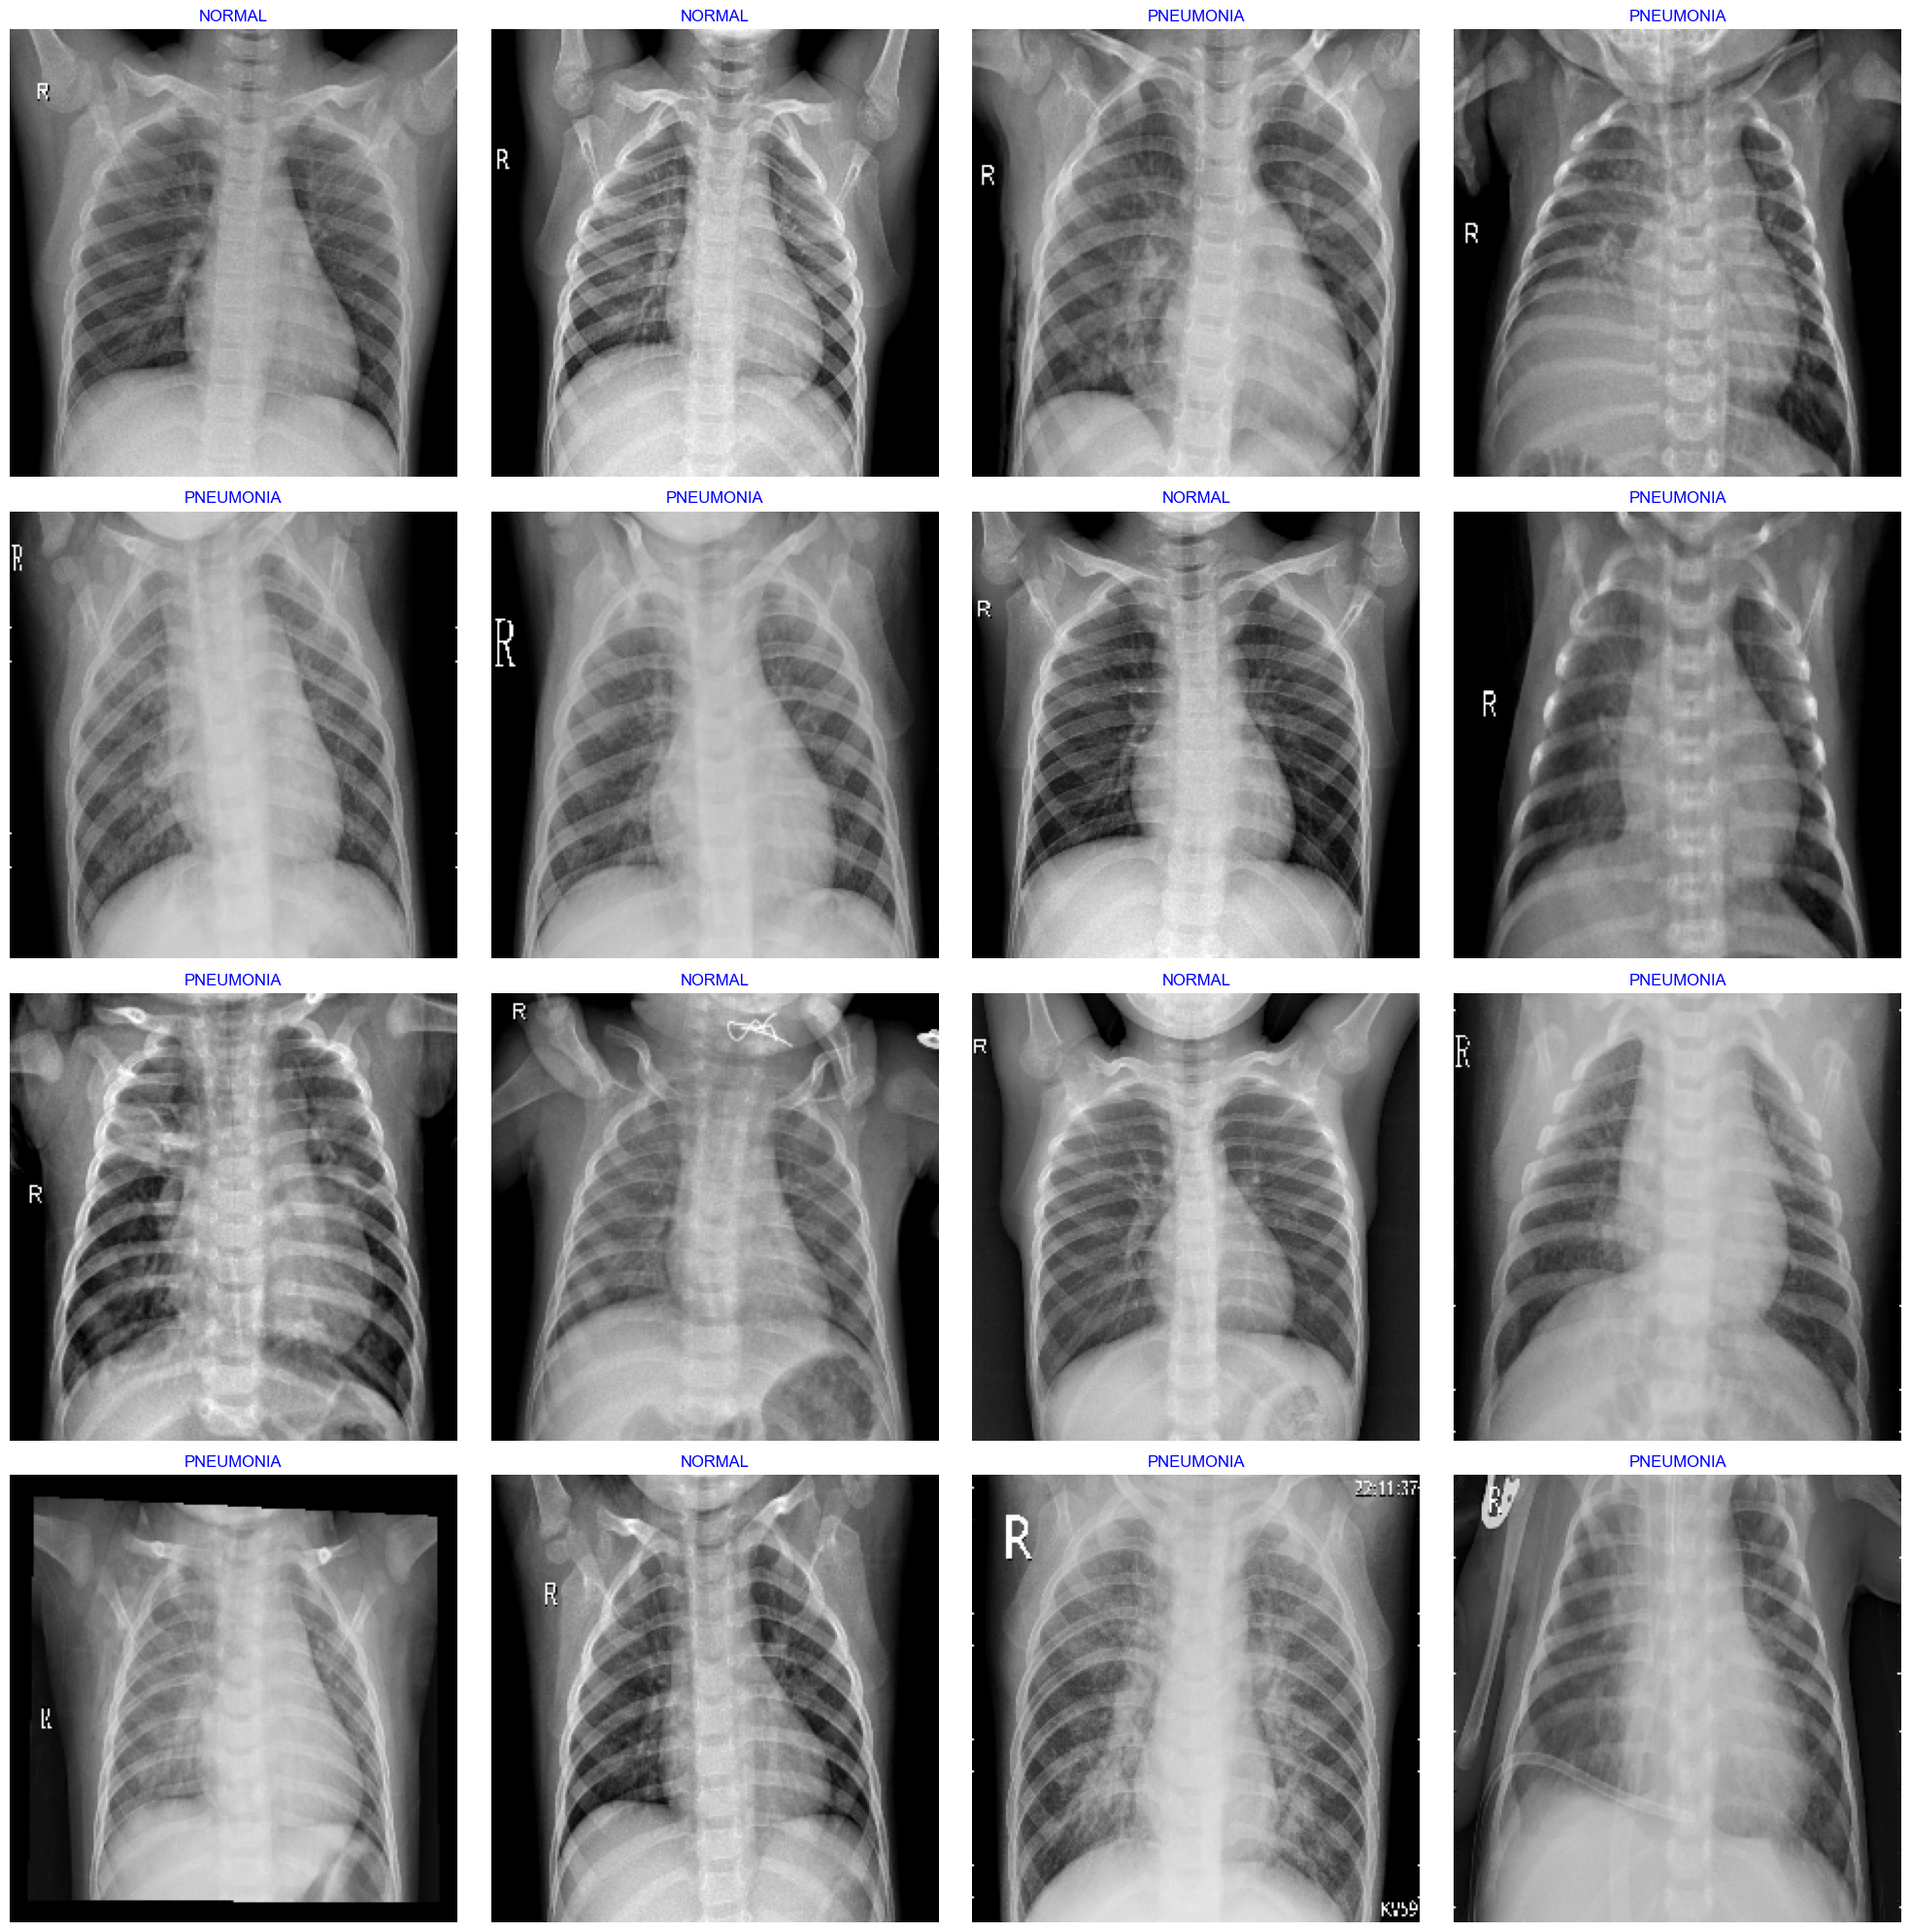

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name,color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# CNN Model
img_size = (224, 224)
channels = 3
img_shape = (img_size[0],img_size[1],channels)
class_count = len(list(train_gen.class_indices.keys())) # 2

# VGG16
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=img_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(class_count,activation='softmax'))

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,050 (80.70 MB)

 Trainable params: 21,154,050 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the data
epochs = 13
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/13
169/326 ━━━━━━━━━━━━━━━━━━━━ 1:12:08 28s/step - accuracy: 0.7025 - loss: 24.5275

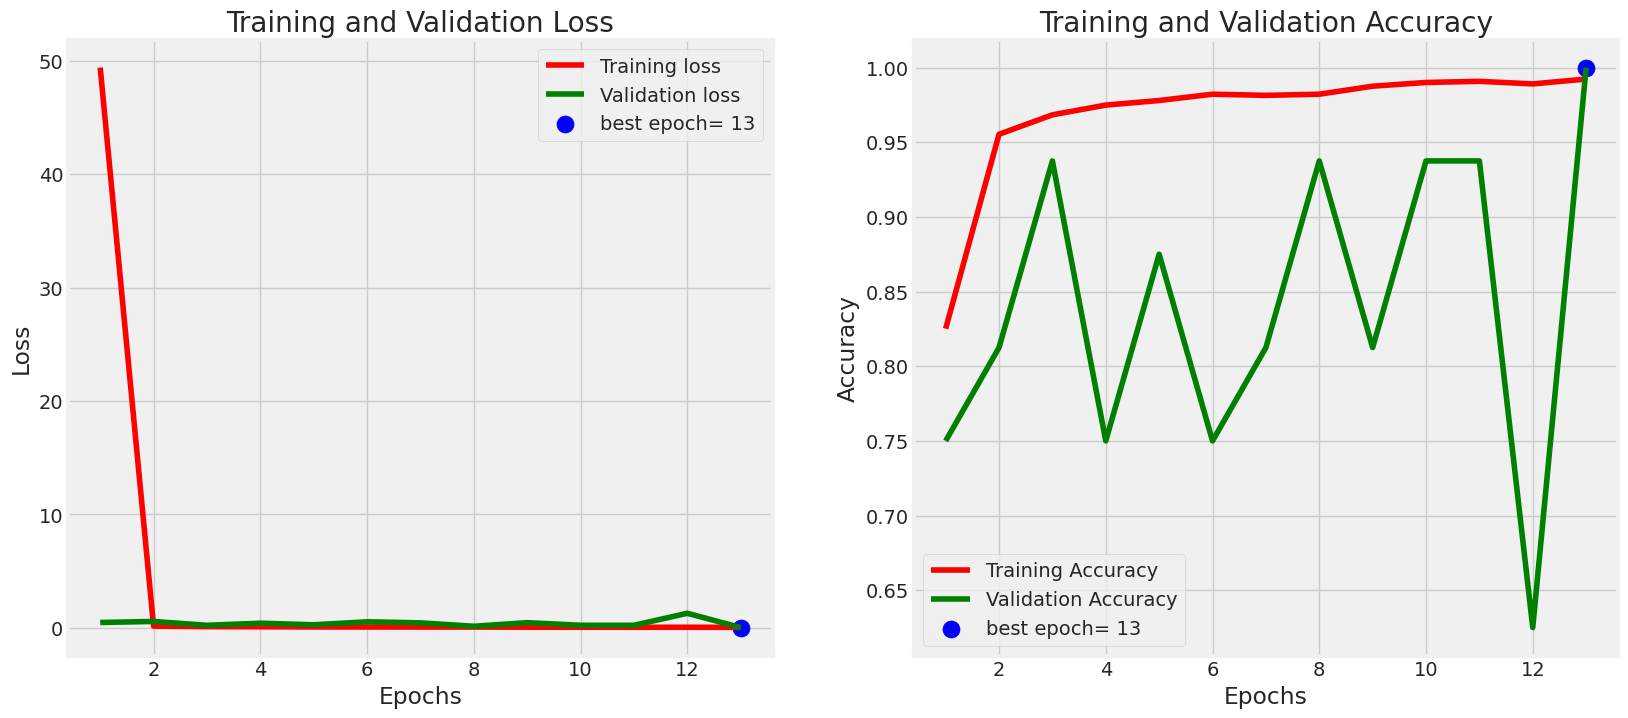

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

# Plot Training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training Loss')
plt.plot(Epochs, val_loss, 'r', label = 'Validation Loss')
plt.scatter(index_loss + 1,val_lowest,s = 150, c = 'blue', label=loss_label)
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s = 150, c = 'blue', label = acc_label)
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Model Evaluation
train_score = model.evaluate(train_gen, verbose=1)
valid_score =   model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy", train_score[1])
print('-' * 20)

print("Validation Loss: ", valid_score[0])
print("Validation Accuracy", valid_score[1])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy", test_score[1])
print('-' * 20)

39/39 [==============================] - 5s 129ms/step - loss: 1.6339 - accuracy: 0.8478
Train Loss:  0.031189754605293274
Train Accuracy:  0.9871549010276794
--------------------
Validation Loss:  0.0017894686898216605
Validation Accuracy:  1.0
--------------------
Test Loss:  1.6339048147201538
Test Accuracy:  0.8477563858032227


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

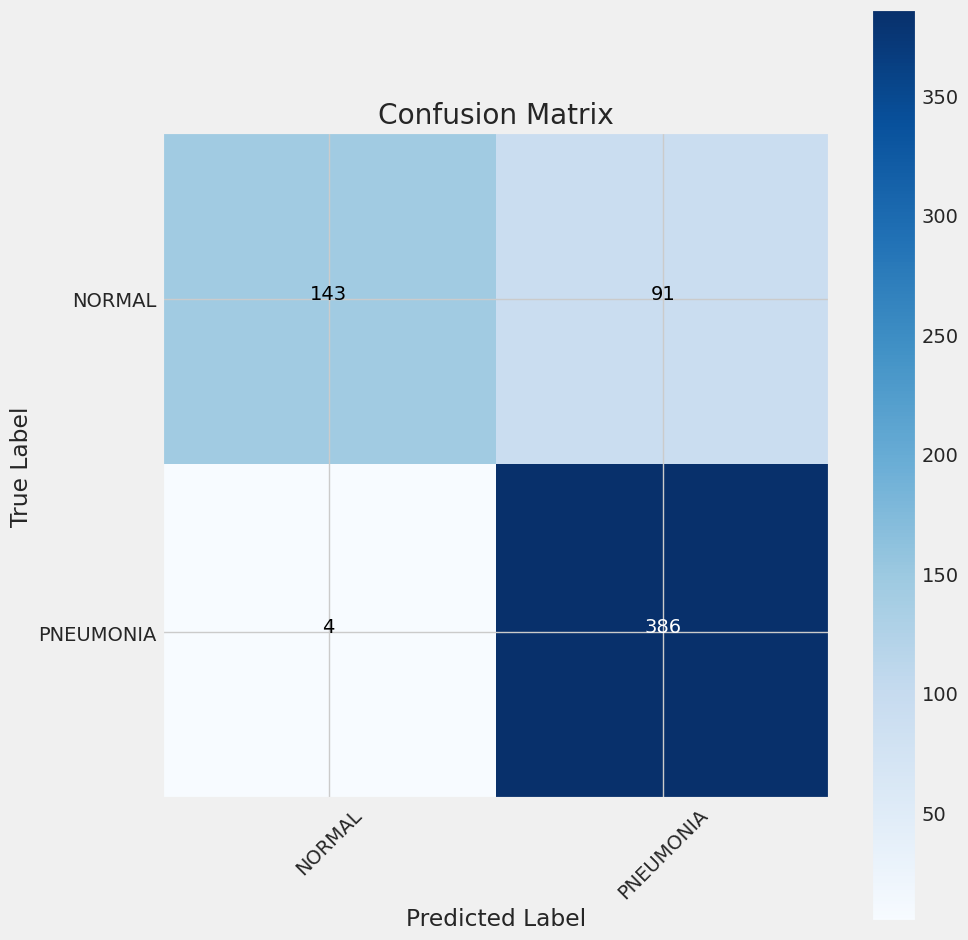

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.97      0.61      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



In [ ]:
model.save('/Model/Pneumonia.h5')